<a href="https://colab.research.google.com/github/nataliasbsg/Dataset_animales/blob/main/AnalisisdeResultados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerías

Se importan todas las librerías necesarias para realizar la red de clasificación de animales. En este caso se trabajará con librerías para trabajar con las imágenes y TensorFlow para las redes.

In [2]:
# Importación de archivos desde drive
from google.colab import drive

# Tratamiento de imágenes
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import shutil
import zipfile


# Librerías para la red
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


# Lectura de imágenes desde Drive
Se accede a las imagenes contenidas en Drive. En este caso hay tres niveles de carpetas:
1. Base de Datos general. Una sola carpeta que contiene todas las familias de animales que se quieren estudiar. Por ejemplo: "Base de datos de animales".
2. Conjunto de carpetas de familias de animales que a su vez contienen las carpetas de especies animales de la misma familia (categories). Por ejemplo:  dentro de "Base de datos de animales" encontraríamos "Cánidos" y "Felinos".
3. Conjunto de carpetas de especies animales (subcategories). Contienen las imagenes con las que se va a trabajar. Por ejemplo: dentro de "Felinos" encontraríamos "Linces" y "Gatos".


Se estudiará la pertenencia a las familias de cada imagen y para ello se numerará la cantidad de imágenes de cada familia (no de cada especie) y se hará una copia de las imágenes clasificadas en la máquina virtual.

En este caso las familias y las especies de cada una son las siguientes:
0. Cánidos: zorros.
1. Cérvidos: ciervos y gamos.
2. Felinos: gatos y linces.
3. Herpéstidos: meloncillos.
4. Lepóridos: conejos y liebres.
5. Mustélidos: tejones.
6. Suidos: jabalíes.
7. Vivérridos: ginetas.

In [11]:
!wget --no-check-certificate \
    "https://github.com/nataliasbsg/Dataset_animales/archive/refs/heads/master.zip" \
    -O "/tmp/Dataset_animales.zip"


zip_ref = zipfile.ZipFile('/tmp/Dataset_animales.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-07-02 18:11:12--  https://github.com/nataliasbsg/Dataset_animales/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/nataliasbsg/Dataset_animales/zip/main [following]
--2022-07-02 18:11:12--  https://codeload.github.com/nataliasbsg/Dataset_animales/zip/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/Dataset_animales.zip’

/tmp/Dataset_animal     [      <=>           ] 758.34M  21.5MB/s    in 27s     

2022-07-02 18:11:39 (28.3 MB/s) - ‘/tmp/Dataset_animales.zip’ saved [795174380]



In [12]:
# Carpeta raiz
dir = '/tmp/Dataset_animales-main'

# Carpeta donde se almacenan los modelos de redes entrenados
dir_modelos = dir + '/Modelos_Redes_Entrenados'

# Se cargan los modelos de las redes
modelo = tf.keras.models.load_model(dir_modelos + '/clasificador_animales.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_cervidos = tf.keras.models.load_model(dir_modelos + '/clasificador_cérvidos.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_felinos = tf.keras.models.load_model(dir_modelos + '/clasificador_felinos.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_leporidos = tf.keras.models.load_model(dir_modelos + '/clasificador_lepóridos.h5',custom_objects={'KerasLayer':hub.KerasLayer})

# Se carga la base de datos de imagenes que se quieren clasificar
dir_bd = dir + '/BD_Familia_Test'

In [13]:
dict_modelos = {
    "Cervidos": modelo_cervidos,
    "Felinos": modelo_felinos,
    "Leporidos": modelo_leporidos
}

In [14]:
categories = ['Canidos', 'Cervidos', 'Felinos', 'Herpestidos', 'Leporidos', 'Mustelidos', 'Suidos', 'Viverridos']
subcategories = [['Zorro'], ['Ciervo', 'Gamo'], ['Gato montes', 'Lince iberico'], ['Meloncillo'], ['Conejo', 'Liebre'], ['Tejon'], ['Jabali'], ['Gineta']]

categories = ['Cánidos', 'Cérvidos', 'Felinos', 'Herpéstidos', 'Lepóridos', 'Mustélidos', 'Suidos', 'Úrsidos', 'Vivérridos']

subcategories = [['Zorros'], ['Ciervos', 'Gamos'], ['Gatos', 'Linces'], ['Meloncillo'], ['Conejos', 'Liebres'], ['Tejones'], ['Jabalíes'], ['Osos'], ['Gineta']]


In [18]:
class ImagePrediction():
  """ 
  img: ndarray
    Imagen adaptada para trabajar con ella.
  categorie:  int
    Categoria de la imagen.
  subcategorie:  int    
    Subcategoria de la imagen.
  categorie_real_name: str
    Nombre de categoria de la imagen.
  subcategorie_real_name: str
    Nombre de categoria de la imagen.

  categorie_predict_probability:  array[float]
    Probabilidad de la categoria de la imagen predicha.
  subcategorie_predict_probability:  array[float]
    Probabilidad de la subcategoria de la imagen predicha.
  categorie_predict:  int
    Categoria de la imagen predicha.
  subcategorie_predict:  int
    Subcategoria de la imagen predicha.
  categorie_predict_name: str
    Categoria de la imagen predicha.
  subcategorie_predict_name: str
    Subcategoria de la imagen predicha.
  """

  def __init__(self, dir_img, categorie, subcategorie):
    self.img = cv2.imread(dir_img)
    self.img = np.array(self.img).astype(float)/255
    self.img = cv2.resize(self.img, (224,224))
    self.img = np.array(self.img).astype(float)
    self.categorie = categories.index(categorie)
    self.subcategorie = subcategories[self.categorie].index(subcategorie)
    self.categorie_real_name = categories[self.categorie]
    self.subcategorie_real_name = subcategories[self.categorie][self.subcategorie]
    self.predict()
	
  def predict(self):
    self.categories_predict_probability = modelo.predict(self.img.reshape(-1, 224, 224, 3))[0]
    self.categorie_predict = np.argmax(self.categories_predict_probability)
    self.categorie_predict_name = categories[self.categorie_predict]
    
    if categories[self.categorie_predict] in dict_modelos:
      modelo_subcategorie = dict_modelos[categories[self.categorie_predict]]
      self.subcategorie_predict_probability = modelo_subcategorie.predict(self.img.reshape(-1, 224, 224, 3))[0]
      self.subcategorie_predict = np.argmax(self.subcategorie_predict_probability)
      self.subcategorie_predict_name = subcategories[self.categorie_predict][self.subcategorie_predict]

    else:
      self.subcategorie_predict_probability = [1]
      self.subcategorie_predict = 0
      self.subcategorie_predict_name = subcategories[self.categorie_predict][self.subcategorie_predict]
      

In [20]:
images = []
for i, categorie in  enumerate(categories):
  for subcategorie in subcategories[i]:
    for _img in  os.listdir(dir_bd + "/{}/{}".format(categorie, subcategorie)):
      images.append(ImagePrediction(dir_bd + "/{}/{}/{}".format(categorie, subcategorie,_img), categorie, subcategorie))

In [ ]:
images_show = images
random.shuffle(images_show)
images_show[0].categories_predict_probability

array([1.99721732e-08, 1.11704495e-08, 8.97444163e-09, 1.67703354e-06,
       1.00294741e-07, 9.99997854e-01, 2.99298875e-07, 2.55851713e-08],
      dtype=float32)

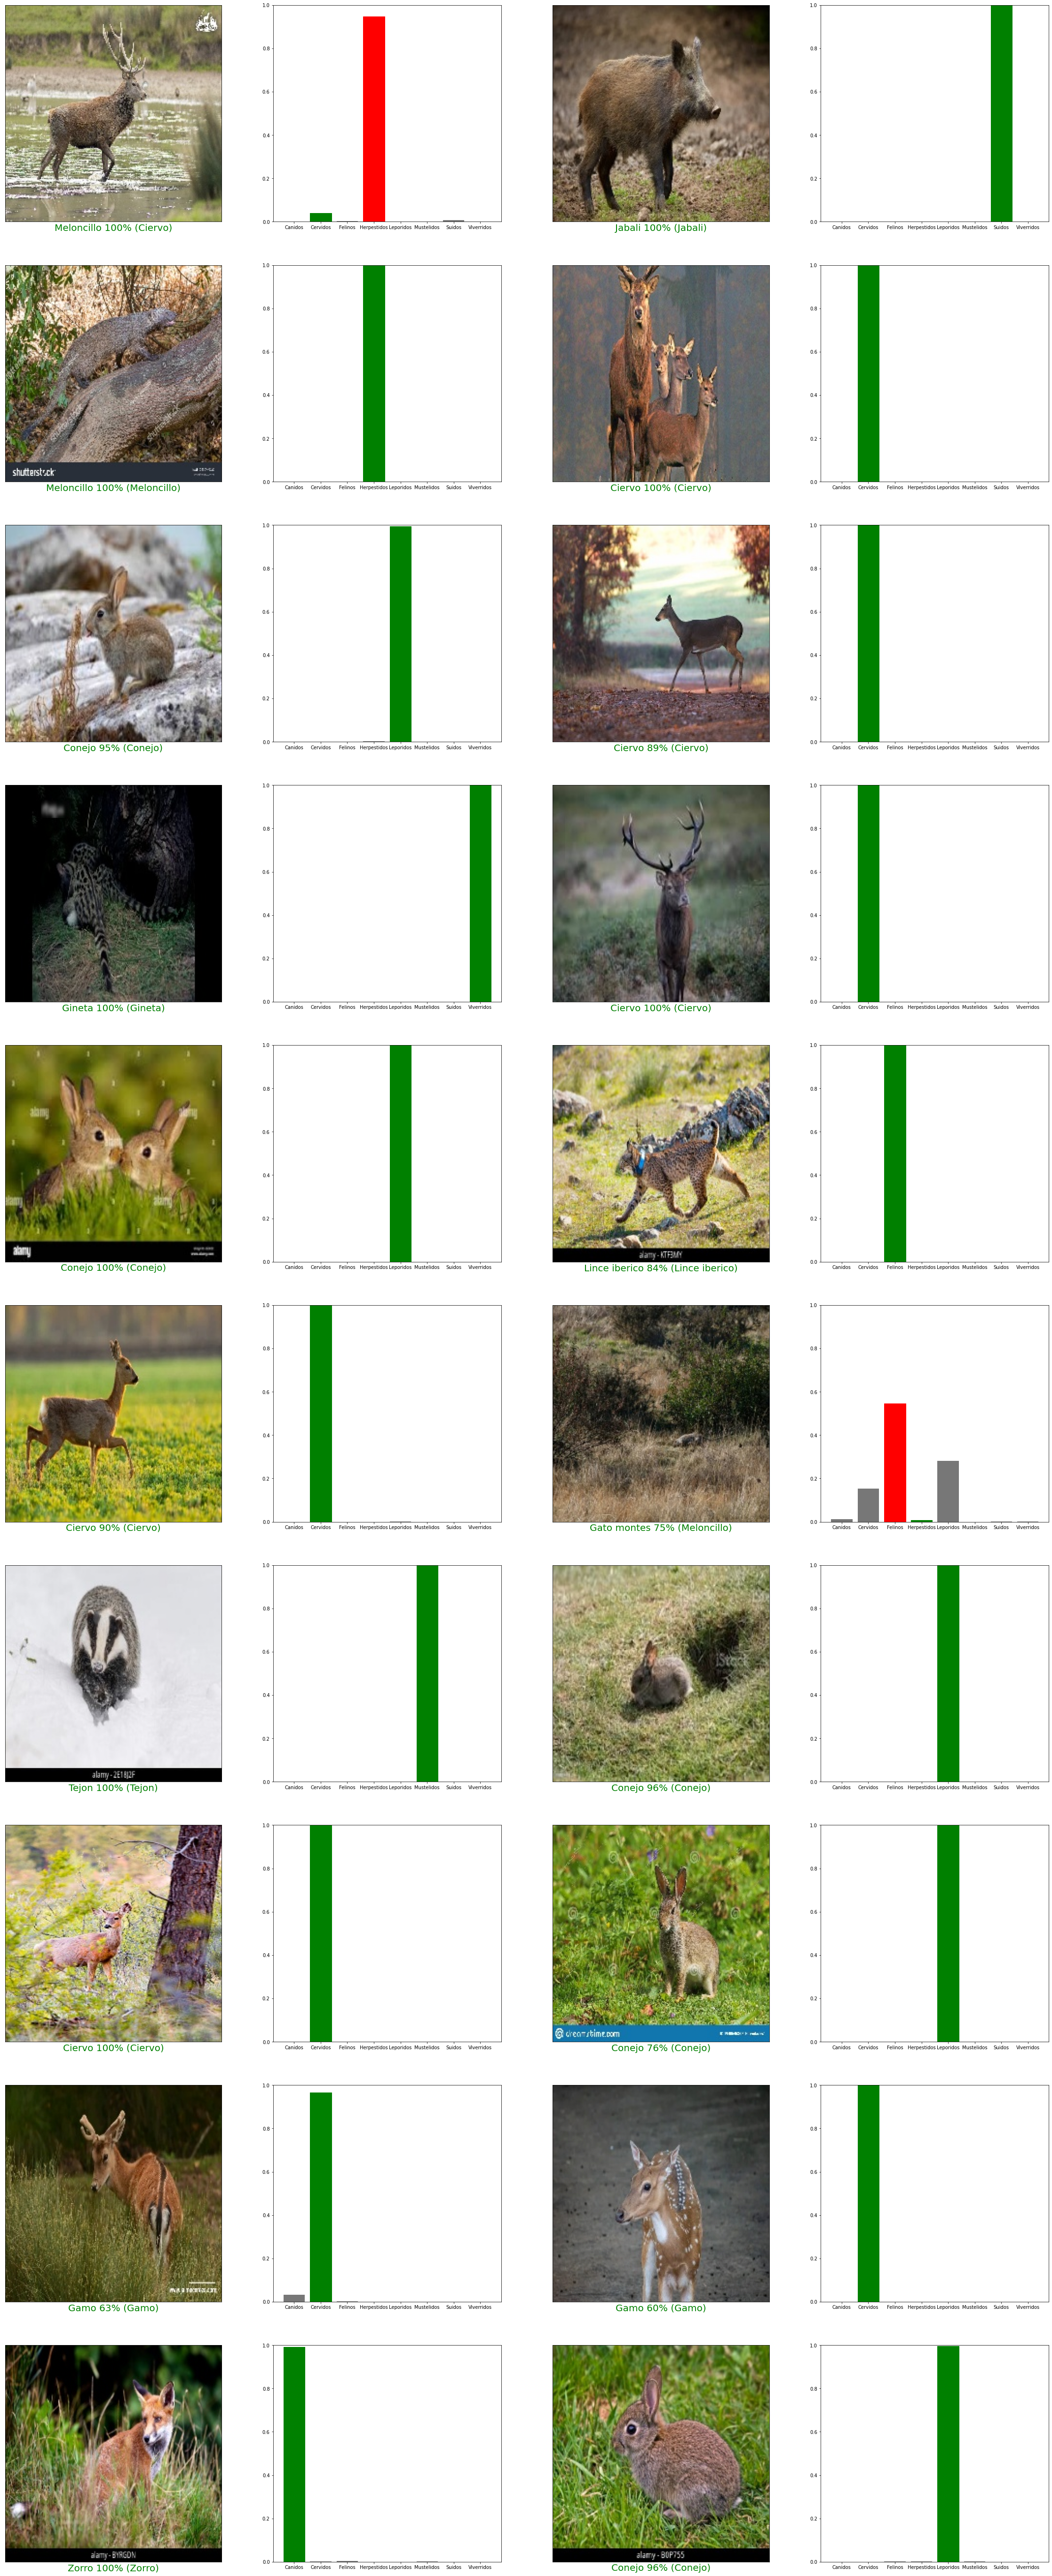

In [21]:
filas = 10
columnas = 2
num_imagenes = filas*columnas
images_show = images
random.shuffle(images_show)

#   graficar_imagen(i, predicciones_prueba, etiquetas_prueba, imagenes_prueba, especie_prediccion, especie_real)
def graficar_imagen(img_graf: ImagePrediction):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = img_graf.img[:,:,[2,1,0]]
  plt.imshow(img)

  #plt.xlabel("{} {:2.0f}% ({})".format(categories[etiqueta_prediccion],
  #                              100*np.max(arr_predicciones),
  #                              categories[etiqueta_real]),
  #                              color=color[i])
  if img_graf.subcategorie_predict == img_graf.subcategorie:
    color = "green"
  else:
    color = "red"

  plt.xlabel("{} {:2.0f}% ({})".format(img_graf.subcategorie_predict_name,
                                100*np.max(img_graf.subcategorie_predict_probability),
                                img_graf.subcategorie_real_name), color=color, fontsize=20)
                                
  
def graficar_valor_arreglo(arr_predicciones, etiqueta_real):
  plt.grid(False)
  # plt.xticks([])
  # plt.yticks([])
  plt.xticks(fontsize=10)
  grafica = plt.bar(categories, arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  # print(etiqueta_real)
  etiqueta_prediccion = int(np.argmax(arr_predicciones, axis=-1))
  # print(etiqueta_prediccion)
  grafica[etiqueta_real].set_color('green')
  if etiqueta_prediccion == etiqueta_real:
    grafica[etiqueta_prediccion].set_color('green')
  else:
    grafica[etiqueta_prediccion].set_color('red')
  #plt.xlabel('Lenguajes de programación')
  
plt.figure(figsize=(20*columnas, 10*filas))


for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(images_show[i])
  # graficar_imagen(images_show[i].img, images_show[i].subcategorie_predict_probability, images_show[i].subcategorie_predict, images_show[i].subcategorie)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(images_show[i].categories_predict_probability, images_show[i].categorie)

## Matrices de confusión


Text(0.5, 1.0, 'Matriz de confusión de familias de animales')

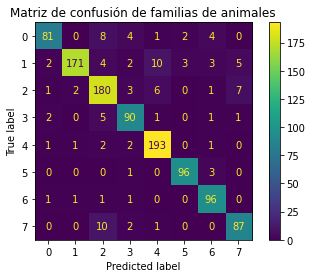

In [23]:
# Pintar imagenes de las carpetas test/{}.format(categorie)
#Pintar imagenes con predicciones, y marcar si son correctas (verde) o incorrectas (roja)


predicciones_prueba = []
imagenes_prueba= []
etiquetas_prueba= []
color = []

predicciones_prueba_2 = []
imagenes_prueba_2= []
etiquetas_prueba_2= []
color_2 = []

filas = 10
columnas = 3
num_imagenes = filas*columnas

data_test = []

y_pred =[]
y_real =[]

for i, categorie in  enumerate(categories):
  for subcategorie in subcategories[i]:
    for _img in  os.listdir(dir_bd + "/{}/{}".format(categorie, subcategorie)):
      _img_read_2 = cv2.imread(dir_bd + "/{}/{}/{}".format(categorie, subcategorie, _img))
      _img_read_2 = np.array(_img_read_2).astype(float)/255
      _img_read_2 = cv2.resize(_img_read_2, (224,224))
      _img_read_2 = np.array(_img_read_2).astype(float)
      etiqueta_aux = np.zeros(len(categories))
      etiqueta_aux[categories.index(categorie)] = 1
      etiqueta_aux_2 = np.zeros(len(subcategories[i]))
      etiqueta_aux_2[subcategories[i].index(subcategorie)] = 1
      data_test.append([_img_read_2, etiqueta_aux, etiqueta_aux_2])

"""
etiqueta_prediccion: int
imagenes_prueba: array
etiquetas_prueba: array
etiqueta_real: int
 
etiquetas_prueba_2:array
predicciones_prueba_2:array
etiqueta_prediccion_2:int

"""
for i, img in enumerate(data_test):
  imagen_prueba, etiqueta_prueba, etiqueta_prueba_2 = img
  imagenes_prueba.append (imagen_prueba)
  etiquetas_prueba.append (etiqueta_prueba)
  predicciones_prueba.append(modelo.predict(imagen_prueba.reshape(-1, 224, 224, 3)))
  etiqueta_prediccion = int(np.argmax(predicciones_prueba[len(predicciones_prueba)-1], axis=-1))
  y_pred.append(etiqueta_prediccion)
  etiqueta_real = np.argmax(etiqueta_prueba)
  y_real.append(etiqueta_real)

ConfusionMatrixDisplay.from_predictions(y_real, y_pred)
plt.title('Matriz de confusión de familias de animales')


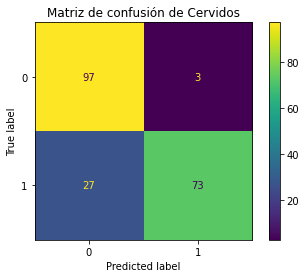

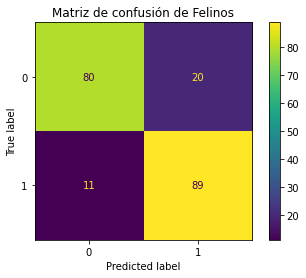

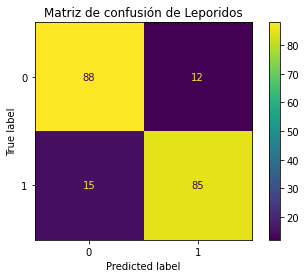

In [24]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


conf_arr = []

for i, categorie in enumerate(categories):
  if not len(subcategories[i]) > 1 :
    continue
  etiquetas_predicciones =[]
  etiquetas_reales =[]
  for subcategorie in subcategories[i]:
    dir = dir_bd + "/{}/{}".format(categorie, subcategorie)
    if not os.path.exists(dir):
      print('La carpeta {} no existe'.format(dir))
      continue
    for img in os.listdir(dir):
      img_read = cv2.imread(dir + '/' + img)
      img_read = np.array(img_read).astype(float)/255
      img_read = cv2.resize(img_read, (224,224))
      etiqueta = subcategories[i].index(subcategorie)
      etiquetas_reales.append (etiqueta)
      if not categorie in dict_modelos.keys():
        print('No se encontro la familia {} en el diccionario'.format(categorie))
        continue
      modelo_sub = dict_modelos[categorie]
      predicciones_prueba = modelo_sub.predict(img_read.reshape(-1, 224, 224, 3))
      etiquetas_predicciones.append(int(np.argmax(predicciones_prueba, axis=-1)))

  
  conf_arr.append(ConfusionMatrixDisplay.from_predictions(etiquetas_reales, etiquetas_predicciones))
  plt.title('Matriz de confusión de {}'.format(categorie))


plt.show()
